In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

# **Prepare Data**

In [2]:
dirs = "/content/drive/My Drive/Data Science Portfolio/2024/Digital Marketing/Netflix/data"
nf_df = pd.read_csv(dirs+"/Netflix Userbase.csv")
nf_df.head()

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month


In [3]:
nf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            2500 non-null   int64 
 1   Subscription Type  2500 non-null   object
 2   Monthly Revenue    2500 non-null   int64 
 3   Join Date          2500 non-null   object
 4   Last Payment Date  2500 non-null   object
 5   Country            2500 non-null   object
 6   Age                2500 non-null   int64 
 7   Gender             2500 non-null   object
 8   Device             2500 non-null   object
 9   Plan Duration      2500 non-null   object
dtypes: int64(3), object(7)
memory usage: 195.4+ KB


- no null rows
- date features are in string data type

In [4]:
nf_df.describe()

,User ID,Monthly Revenue,Age
count,2500.00000,2500.000000,2500.000000
mean,1250.50000,12.508400,38.795600
std,721.83216,1.686851,7.171778
min,1.00000,10.000000,26.000000
25%,625.75000,11.000000,32.000000
50%,1250.50000,12.000000,39.000000
75%,1875.25000,14.000000,45.000000
max,2500.00000,15.000000,51.000000


### **Transform Date features**

In [5]:
# Convert date features to datetime
nf_df["joined date"] = pd.to_datetime(nf_df["Join Date"])
nf_df["last payment date"] = pd.to_datetime(nf_df["Last Payment Date"])

# Create dataframe copy
nf_copy = nf_df.copy()

# Drop the date columns with string data type
nf_copy.drop(["Join Date", "Last Payment Date"], axis=1, inplace=True)

In [136]:
# Define the bins for the age groups and the corresponding labels
bins = [20, 30, 40, 60]
labels = ['20-29', '30-39', '40-60']

# Create the age group column using pd.cut
nf_copy['age_group'] = pd.cut(nf_copy['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# **Exploratory Analysis**

In [6]:
avg_age = nf_copy.groupby(['Subscription Type'])["Age"].mean().reset_index()
avg_age["Age"] = avg_age["Age"].astype(int)
avg_age

,Subscription Type,Age
0,Basic,38
1,Premium,38
2,Standard,39


In [7]:
nf_copy.groupby(['Gender'])["User ID"].count().reset_index()

,Gender,User ID
0,Female,1257
1,Male,1243


[]

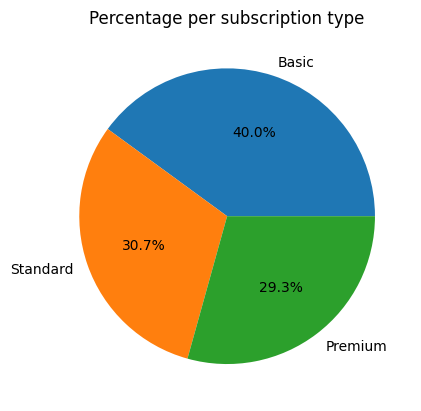

In [9]:
subs_type = nf_copy["Subscription Type"].value_counts().reset_index().rename(columns={"count": "Count"})

plt.pie(subs_type["Count"],
        labels=subs_type["Subscription Type"],
        autopct='%1.1f%%')
plt.title("Percentage per subscription type")
plt.plot()

- Basic is more preferred subscription.
- It follows by Standard, and Premium subscription.

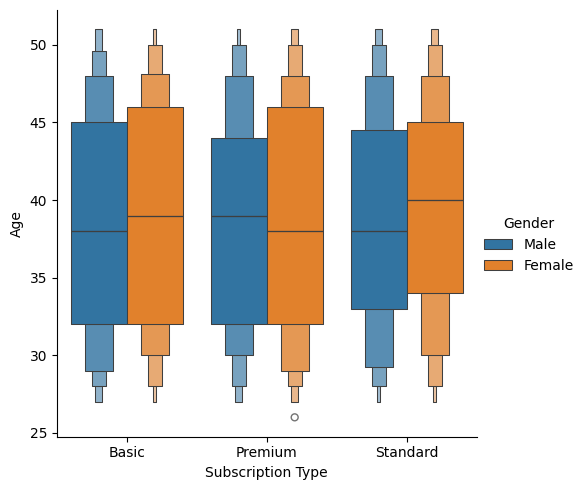

In [10]:
sns.catplot(
    data=nf_copy,
    x="Subscription Type",
    y="Age",
    hue="Gender",
    kind="boxen")

- We can see that for Basic, and Premium subs, patronage among female are more widely distributed compare to male.
- For standard subs, male has fatter distribution and shorter tails than females.
- youngest user (age=26) came from Premium subs.
- overall,
  - users as old as 50+ can subscribe to either of the three subs type.
  - average age across three subscription type are between 38-39 years old.

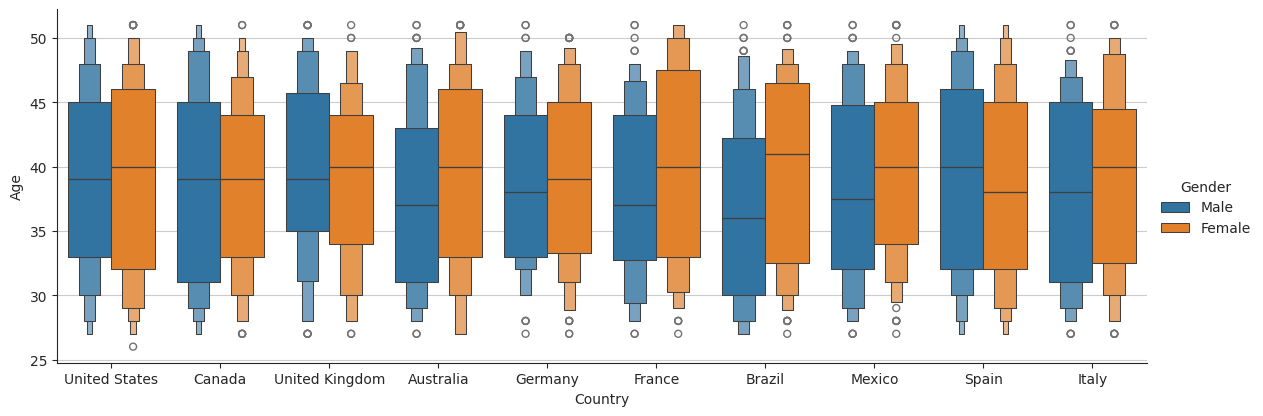

In [13]:
sns.set_style("ticks",{'axes.grid' : True})
sns.catplot(
    data=nf_copy,
    x="Country",
    y="Age",
    hue="Gender",
    kind="boxen",
    height=4.27,
    aspect=11.7/4.27)

### **Analyze last month dues**

In [17]:
# Set latest date
latest_date = nf_copy["last payment date"].max()
latest_month = 12

# Create new features: month, year
nf_copy["payment month"] = nf_copy["last payment date"].dt.month
nf_copy["payment year"] = nf_copy["last payment date"].dt.year

nf_copy["joined month"] = nf_copy["joined date"].dt.month
nf_copy["joined year"] = nf_copy["joined date"].dt.year

In [18]:
def month_difference_series(date_series1, date_series2):
    # Calculate year and month difference where
    # both inputs are series
    year_diff = date_series2.dt.year - date_series1.dt.year
    month_diff = date_series2.dt.month - date_series1.dt.month

    # Calculate the total month difference
    total_months = year_diff * 12 + month_diff

    return total_months

def month_difference(reference_date, date_series):
    # Calculate year and month difference
    # ref date is single value, while co-ref date is a series
    year_diff = date_series.dt.year - reference_date.year
    month_diff = date_series.dt.month - reference_date.month

    # Calculate the total month difference
    total_months = year_diff * 12 + month_diff

    return np.abs(total_months)


nf_copy["No. of Months Subscribed"] = month_difference_series(nf_copy["joined date"], nf_copy["last payment date"])
nf_copy["No. of Lapsed month"] = month_difference(nf_copy["last payment date"].max(), nf_copy["last payment date"], )
nf_copy.head()

,User ID,Subscription Type,Monthly Revenue,Country,Age,Gender,Device,Plan Duration,joined date,last payment date,payment month,payment year,No. of Months Subscribed,No. of Lapsed month,joined month,joined year
0,1,Basic,10,United States,28,Male,Smartphone,1 Month,2022-01-15,2023-10-06,10,2023,21,2,1,2022
1,2,Premium,15,Canada,35,Female,Tablet,1 Month,2021-05-09,2023-06-22,6,2023,25,6,5,2021
2,3,Standard,12,United Kingdom,42,Male,Smart TV,1 Month,2023-02-28,2023-06-27,6,2023,4,6,2,2023
3,4,Standard,12,Australia,51,Female,Laptop,1 Month,2022-10-07,2023-06-26,6,2023,8,6,10,2022
4,5,Basic,10,Germany,33,Male,Smartphone,1 Month,2023-01-05,2023-06-28,6,2023,5,6,1,2023


### **Subscription per month**

Text(0.5, 0, 'Month joined')

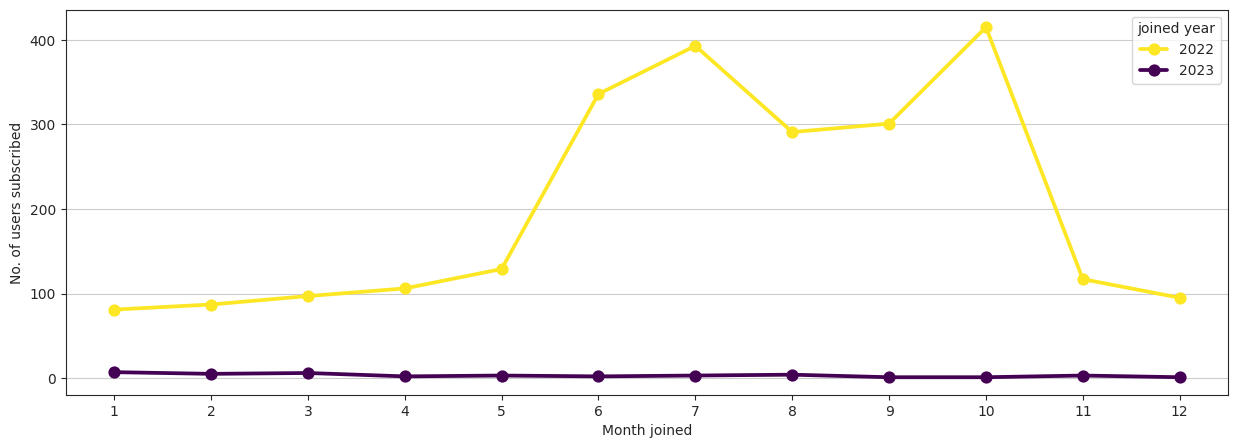

In [92]:
grouped_by_joined = nf_copy.groupby(["joined month", "joined year"])["User ID"].count().reset_index()
plt.figure(figsize=(15, 5))
sns.pointplot(grouped_by_joined[grouped_by_joined["joined year"]!=2021],
             x="joined month",
             y="User ID",
             hue="joined year",
             palette="viridis_r")

plt.ylabel("No. of users subscribed")
plt.xlabel("Month joined")

- For year 2022, the highest subscription rate comes from october, followed by the month of july.
- For year 2023, the subscription falls for almost 0. While year 2021, has no presence at all.

### **Percentage difference (Month-to-month)**

[]

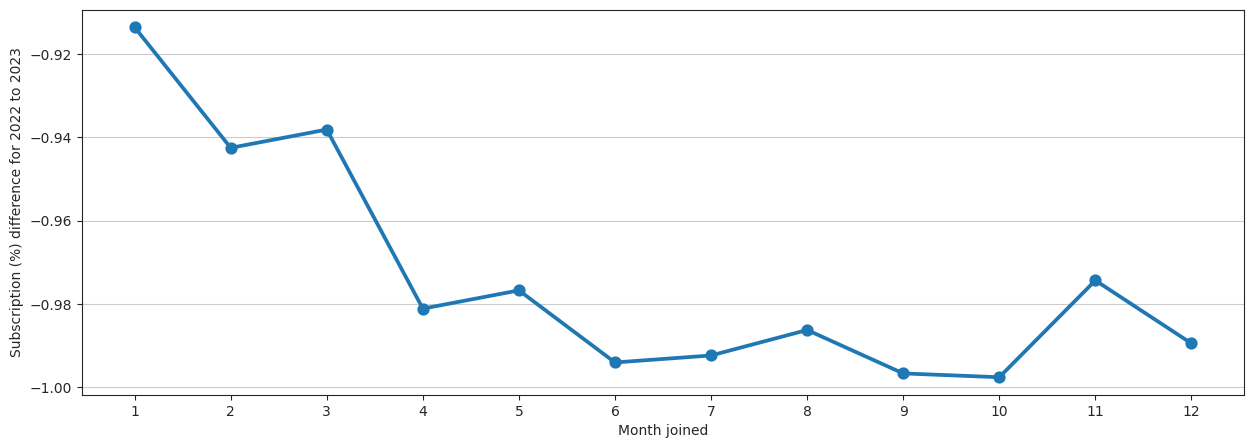

In [86]:
pivot_table = pd.pivot_table(grouped_by_joined,
               index="joined month",
               columns="joined year",
               values="User ID").reset_index()

pivot_df = pd.DataFrame(pivot_table)
pivot_df["difference (%) 22-23"] =( pivot_df[2023] - pivot_df[2022]) / pivot_df[2022]
plt.figure(figsize=(15, 5))
sns.pointplot(pivot_df,
             x="joined month",
             y="difference (%) 22-23",
            ci=True)
plt.ylabel("Subscription (%) difference for 2022 to 2023")
plt.xlabel("Month joined")
plt.plot()

- October experiences the largest subscription drop, followed by september.
- January experiences the lowest subscription drop, followed by march.

### **Analyzing the payment lapse**

<Axes: xlabel='No. of Lapsed month', ylabel='Count'>

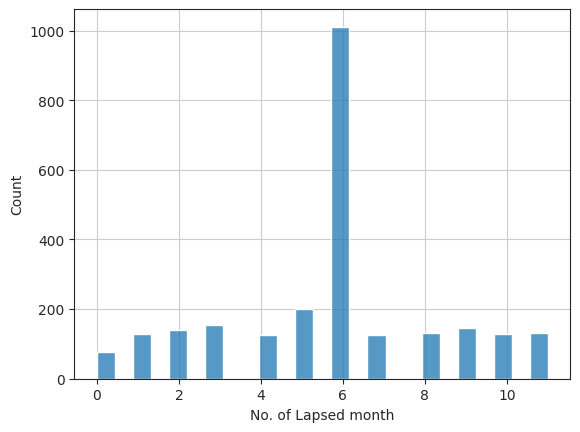

In [96]:
sns.histplot(nf_copy, x="No. of Lapsed month")

In [97]:
nf_copy.columns

Index(['User ID', 'Subscription Type', 'Monthly Revenue', 'Country', 'Age',
       'Gender', 'Device', 'Plan Duration', 'joined date', 'last payment date',
       'payment month', 'payment year', 'No. of Months Subscribed',
       'No. of Lapsed month', 'joined month', 'joined year'],
      dtype='object')

In [166]:
lapsed_grp_device = nf_copy.groupby(["No. of Lapsed month", "No. of Months Subscribed", "Device",])["User ID"].count().reset_index()
lapsed_grp_country = nf_copy.groupby(["No. of Lapsed month", "No. of Months Subscribed", "Country",])["User ID"].count().reset_index()
lapsed_grp_age = nf_copy.groupby(["No. of Lapsed month", "No. of Months Subscribed", "age_group",])["User ID"].count().reset_index()
lapsed_grp_gender = nf_copy.groupby(["No. of Lapsed month", "No. of Months Subscribed", "Gender",])["User ID"].count().reset_index()

lapsed_grp_device["No. of Lapsed month"] = lapsed_grp["No. of Lapsed month"].astype(str)
lapsed_grp_country["No. of Lapsed month"] = lapsed_grp_country["No. of Lapsed month"].astype(str)
lapsed_grp_age["No. of Lapsed month"] = lapsed_grp_age["No. of Lapsed month"].astype(str)
lapsed_grp_gender["No. of Lapsed month"] = lapsed_grp_gender["No. of Lapsed month"].astype(str)

In [177]:
# nf_copy.groupby(["No. of Lapsed month", "No. of Months Subscribed", "Device"])[["User ID"]].count().reset_index()

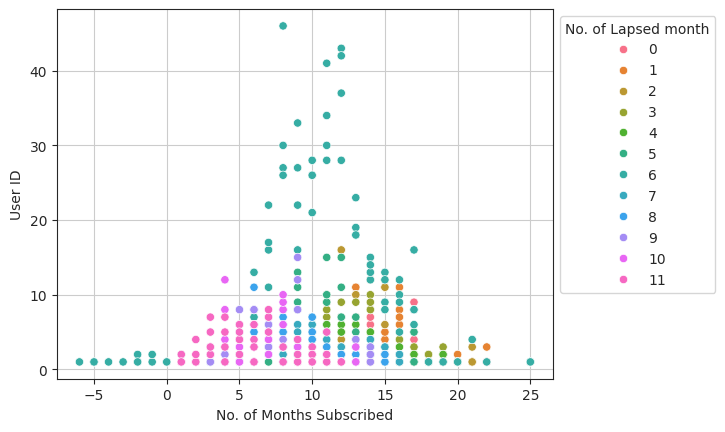

In [152]:
ax = sns.scatterplot(lapsed_grp_device,
            x="No. of Months Subscribed",
            y="User ID",
            hue="No. of Lapsed month")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(49.10521797839506, 0.5, 'Subscription count')

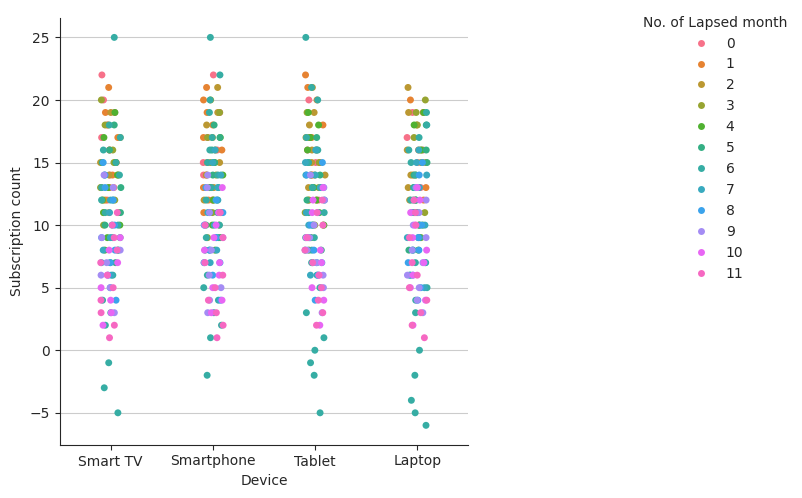

In [173]:
ax = sns.catplot(lapsed_grp_device,
            x="Device",
            y="No. of Months Subscribed",
            hue="No. of Lapsed month")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Subscription count")

Text(37.59197349504061, 0.5, 'Subscription count')

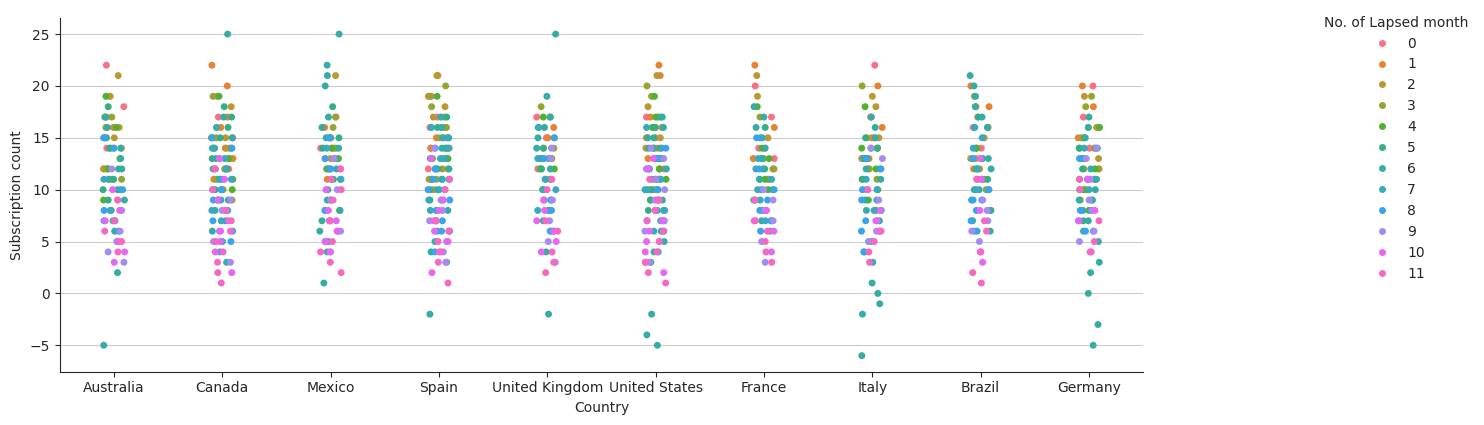

In [174]:
ax = sns.catplot(lapsed_grp_country,
            x="Country",
            y="No. of Months Subscribed",
            hue="No. of Lapsed month",
            height=4.27,
            aspect=11.7/4.27)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Subscription count")

Text(40.20002044423339, 0.5, 'Age group')

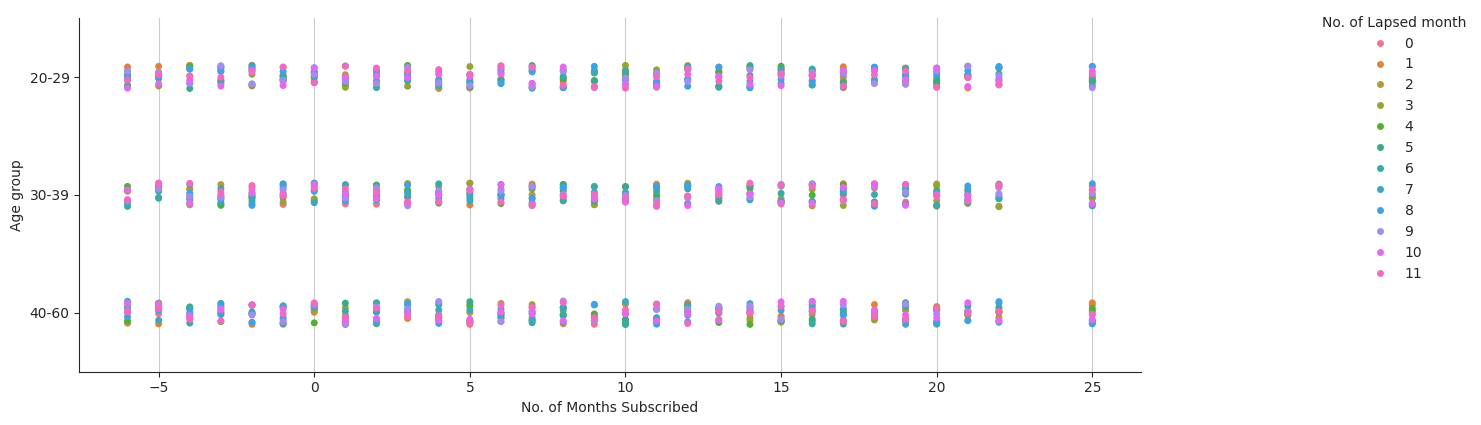

In [175]:
ax = sns.catplot(lapsed_grp_age,
                 x="No. of Months Subscribed",
                 y="age_group",
                  hue="No. of Lapsed month",
                  height=4.27,
                  aspect=11.7/4.27)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Age group")

Text(41.56218509285635, 0.5, 'Gender')

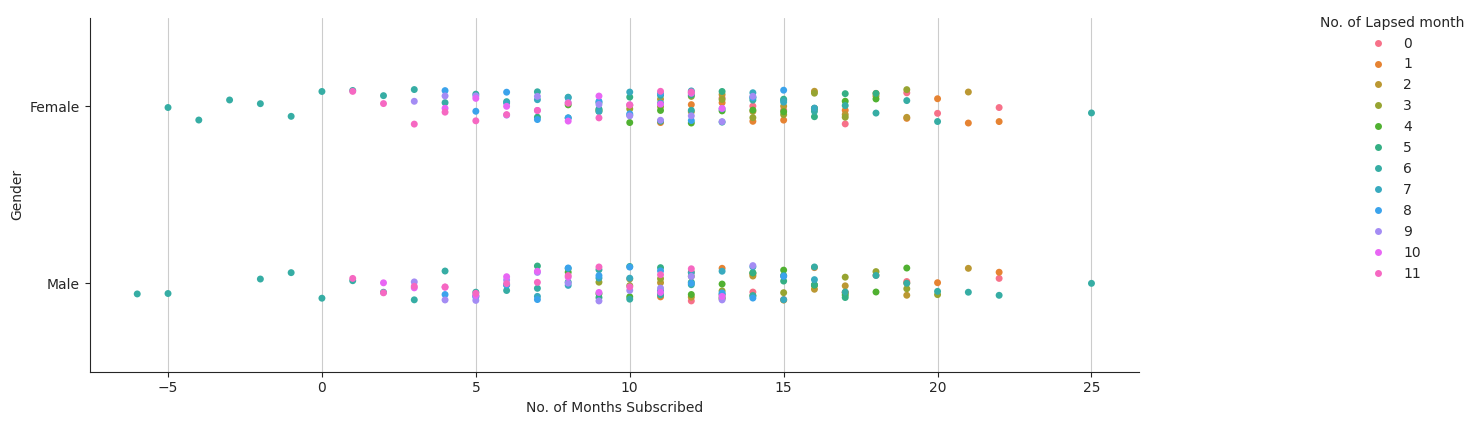

In [176]:
ax = sns.catplot(lapsed_grp_gender,
                 x="No. of Months Subscribed",
                 y="Gender",
                  hue="No. of Lapsed month",
                  height=4.27,
                  aspect=11.7/4.27)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Gender")